In [9]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import time
import subprocess
from tqdm import tqdm

In [10]:
%%writefile integral.py
from mpi4py import MPI
from scipy.stats import norm
import numpy as np
import time

mu = 10
sigma = 2
N = 2**25
a = mu - 5 * sigma
b = mu + 5 * sigma
dx = (b - a) / (N-1)

def f(x):
    return norm.pdf(x, mu, sigma)

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

my_N = (N - 1) // size
remainder = (N - 1) % size

if (rank < remainder):
    my_N += 1

if (rank - 1) < remainder:
    shift = rank * (my_N + 1)
else:
    shift = (my_N + 1) * remainder + my_N * (rank - remainder)

x = np.linspace(0, dx * my_N, my_N + 1) + shift * dx + a
integral_part = np.sum(f((x[1:] + x[:-1]) / 2) * dx)
global_result = None

root = 0
if rank==root:
    global_result = np.empty(1, dtype=np.float64)

comm.Reduce(integral_part, global_result, op=MPI.SUM, root=root)

if rank==root:
    print(global_result, end='')
MPI.Finalize()

Overwriting integral.py


In [11]:
time_elapsed_array = []
errors_array = []
N_max = 10

for j in tqdm(range(1, N_max)):
    start = time.perf_counter()
    res = subprocess.run([f"mpirun -n {j} --allow-run-as-root --oversubscribe python3 integral.py"], shell=True, capture_output=True)
    elapsed_time = time.perf_counter() - start
    time_elapsed_array.append(elapsed_time)
    errors_array.append(float(res.stdout.decode("utf-8")[1:-1]))

time_elapsed_array = np.array(time_elapsed_array)
errors_array = 1 - np.array(errors_array)

100%|██████████| 9/9 [00:49<00:00,  5.46s/it]


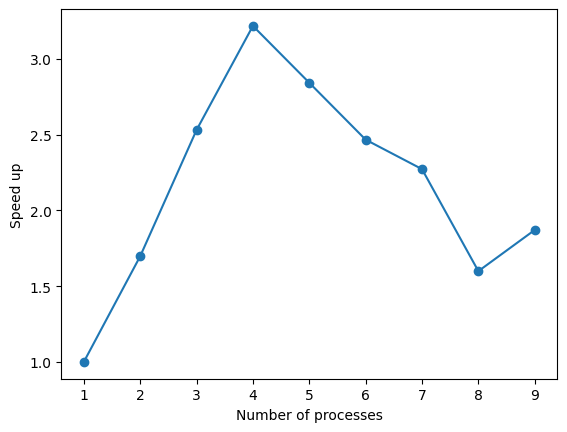

In [12]:
plt.plot([i for i in range(1, N_max)], time_elapsed_array[0] / time_elapsed_array, '-o')
plt.xlabel('Number of processes')
plt.ylabel('Speed up')
plt.show()

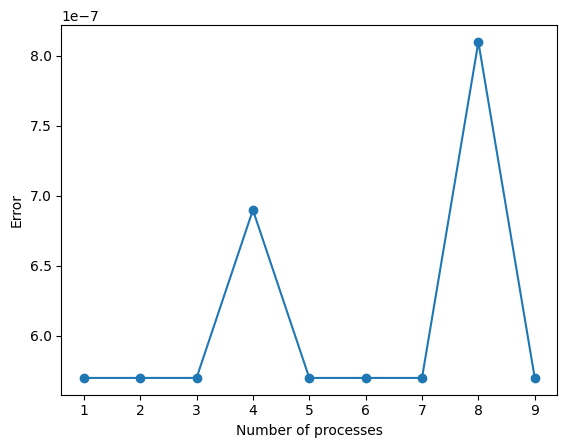

In [13]:
plt.plot([i for i in range(1, N_max)], errors_array, '-o')
plt.xlabel('Number of processes')
plt.ylabel('Error')
plt.show()

As we can see, error is really small, and final result should be 1, since we calculate integral over pdf. Thus, our calculations are correct.